In [1]:
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import math
from math import sqrt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
import shap

Read data in and clean

In [2]:
# Import csv file prices_prod
source_df = pd.read_csv('./Resources/prices_prod.csv', parse_dates=['date'], index_col= 'date' )
source_df.reset_index(inplace=True)
source_df.sort_index(inplace=True)
source_df.head()
source_df.dropna()

,date,year_month,geography,type,avg_price,prices_total_volume,units_4046,units_4225,units_4770,total_bags,s_bags,l_bags,xl_bags,status,prod_total_volume,california,chile,mexico,peru,colombia
0,2018-01-07,1/1/2018,Albany,conventional,1.13,98540.22,2940.63,76192.61,42.63,19364.35,8633.09,10707.93,23.33,actual,45670156,899349,519433,44251374,0,0
1,2018-01-07,1/1/2018,Albany,organic,1.54,4816.90,43.51,412.17,0.00,4361.22,4357.89,3.33,0.00,actual,45670156,899349,519433,44251374,0,0
2,2018-01-07,1/1/2018,Atlanta,conventional,0.98,713915.80,364463.12,47869.41,1459.65,300123.62,217644.43,78287.66,4191.53,actual,45670156,899349,519433,44251374,0,0
3,2018-01-07,1/1/2018,Atlanta,organic,1.53,15714.11,405.37,4195.19,0.00,11113.55,7883.61,3229.94,0.00,actual,45670156,899349,519433,44251374,0,0
4,2018-01-07,1/1/2018,Baltimore/Washington,conventional,1.50,771313.78,89883.07,466602.79,4167.07,210660.85,189304.53,21356.32,0.00,actual,45670156,899349,519433,44251374,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14467,2020-09-06,9/1/2020,TotalUS,organic,1.62,1754057.30,105106.37,144137.69,4186.01,1500627.23,848427.68,652190.75,8.80,actual,52693480,8453470,0,39925907,4314102,0
14468,2020-09-06,9/1/2020,West,conventional,0.95,9026449.59,1975837.16,1152252.54,33199.60,5864954.14,2726358.78,3060566.48,78028.88,actual,52693480,8453470,0,39925907,4314102,0
14469,2020-09-06,9/1/2020,West,organic,1.58,315771.42,31032.50,28880.42,1192.43,254666.07,100807.93,153849.34,8.80,actual,52693480,8453470,0,39925907,4314102,0
14470,2020-09-06,9/1/2020,WestTex/NewMexico,conventional,0.75,1212992.28,397029.46,76486.29,39407.07,700069.46,482659.19,215394.65,2015.62,actual,52693480,8453470,0,39925907,4314102,0


In [3]:
# Drop the non-beneficial columns, 'status' and 'prod'.
prices_df = source_df.drop(['year_month', 'status', 'prices_total_volume', 'total_bags', 'prod_total_volume', 'california', 'chile', 'mexico', 'peru', 'colombia'],axis=1)
prices_df

,date,geography,type,avg_price,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags
0,2018-01-07,Albany,conventional,1.13,2940.63,76192.61,42.63,8633.09,10707.93,23.33
1,2018-01-07,Albany,organic,1.54,43.51,412.17,0.00,4357.89,3.33,0.00
2,2018-01-07,Atlanta,conventional,0.98,364463.12,47869.41,1459.65,217644.43,78287.66,4191.53
3,2018-01-07,Atlanta,organic,1.53,405.37,4195.19,0.00,7883.61,3229.94,0.00
4,2018-01-07,Baltimore/Washington,conventional,1.50,89883.07,466602.79,4167.07,189304.53,21356.32,0.00
...,...,...,...,...,...,...,...,...,...,...
14467,2020-09-06,TotalUS,organic,1.62,105106.37,144137.69,4186.01,848427.68,652190.75,8.80
14468,2020-09-06,West,conventional,0.95,1975837.16,1152252.54,33199.60,2726358.78,3060566.48,78028.88
14469,2020-09-06,West,organic,1.58,31032.50,28880.42,1192.43,100807.93,153849.34,8.80
14470,2020-09-06,WestTex/NewMexico,conventional,0.75,397029.46,76486.29,39407.07,482659.19,215394.65,2015.62


In [4]:
# Drop rows that are totals for included sub areas and thus duplicates
prices_df = prices_df.drop(prices_df[(source_df.geography == 'California') | 
                                (prices_df.geography == 'Southeast') |
                                   (source_df.geography == 'TotalUS') |
                                   (source_df.geography == 'Midsouth') |
                                   (source_df.geography == 'Northeast') |
                                   (source_df.geography == 'Southeast') |
                                   (source_df.geography == 'West') ].index)
prices_df

,date,geography,type,avg_price,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags
0,2018-01-07,Albany,conventional,1.13,2940.63,76192.61,42.63,8633.09,10707.93,23.33
1,2018-01-07,Albany,organic,1.54,43.51,412.17,0.00,4357.89,3.33,0.00
2,2018-01-07,Atlanta,conventional,0.98,364463.12,47869.41,1459.65,217644.43,78287.66,4191.53
3,2018-01-07,Atlanta,organic,1.53,405.37,4195.19,0.00,7883.61,3229.94,0.00
4,2018-01-07,Baltimore/Washington,conventional,1.50,89883.07,466602.79,4167.07,189304.53,21356.32,0.00
...,...,...,...,...,...,...,...,...,...,...
14463,2020-09-06,Syracuse,organic,1.47,263.28,151.82,0.00,3676.17,508.41,0.00
14464,2020-09-06,Tampa,conventional,0.83,295153.76,19274.90,150.36,340468.87,28822.22,13057.78
14465,2020-09-06,Tampa,organic,1.63,115.22,0.00,0.00,3427.70,1438.89,0.00
14470,2020-09-06,WestTex/NewMexico,conventional,0.75,397029.46,76486.29,39407.07,482659.19,215394.65,2015.62


In [5]:
# Correct the type catagory
prices_df.loc[prices_df['type'] == 'conventional ', 'type'] = 'conventional'
prices_df.groupby('type').size()

type
conventional    6432
organic         6432
dtype: int64

In [6]:
lstmconv_df = prices_df.loc[prices_df['type'] == 'conventional'].copy()
lstmconv_df.drop(['type'],axis=1, inplace=True)
lstmconv_df

,date,geography,avg_price,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags
0,2018-01-07,Albany,1.13,2940.63,76192.61,42.63,8633.09,10707.93,23.33
2,2018-01-07,Atlanta,0.98,364463.12,47869.41,1459.65,217644.43,78287.66,4191.53
4,2018-01-07,Baltimore/Washington,1.50,89883.07,466602.79,4167.07,189304.53,21356.32,0.00
6,2018-01-07,Boise,1.30,45936.53,2658.28,7511.15,21784.14,7752.83,54.72
8,2018-01-07,Boston,1.28,12012.96,557314.83,4961.24,58834.32,52294.16,0.00
...,...,...,...,...,...,...,...,...,...
14458,2020-09-06,Spokane,1.14,21397.20,13840.24,13.49,51882.19,42531.66,50.87
14460,2020-09-06,StLouis,0.96,117719.22,11917.15,204.55,109526.47,2528.58,12056.42
14462,2020-09-06,Syracuse,1.17,12220.36,41553.12,763.81,33963.49,3097.85,893.33
14464,2020-09-06,Tampa,0.83,295153.76,19274.90,150.36,340468.87,28822.22,13057.78


In [7]:
lstmorg_df = prices_df.loc[prices_df['type'] == 'organic'].copy()
lstmorg_df.drop(['type'],axis=1, inplace=True)
lstmorg_df

,date,geography,avg_price,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags
1,2018-01-07,Albany,1.54,43.51,412.17,0.00,4357.89,3.33,0.0
3,2018-01-07,Atlanta,1.53,405.37,4195.19,0.00,7883.61,3229.94,0.0
5,2018-01-07,Baltimore/Washington,1.15,1315.95,9962.10,134.19,70863.80,6.67,0.0
7,2018-01-07,Boise,1.77,42.60,949.08,0.00,552.06,1010.16,0.0
9,2018-01-07,Boston,1.91,14.46,2704.48,0.00,25121.53,2255.53,0.0
...,...,...,...,...,...,...,...,...,...
14459,2020-09-06,Spokane,1.69,56.19,742.91,0.00,1227.77,4779.30,0.0
14461,2020-09-06,StLouis,1.80,1332.38,1139.94,11.40,3419.99,1864.19,0.0
14463,2020-09-06,Syracuse,1.47,263.28,151.82,0.00,3676.17,508.41,0.0
14465,2020-09-06,Tampa,1.63,115.22,0.00,0.00,3427.70,1438.89,0.0


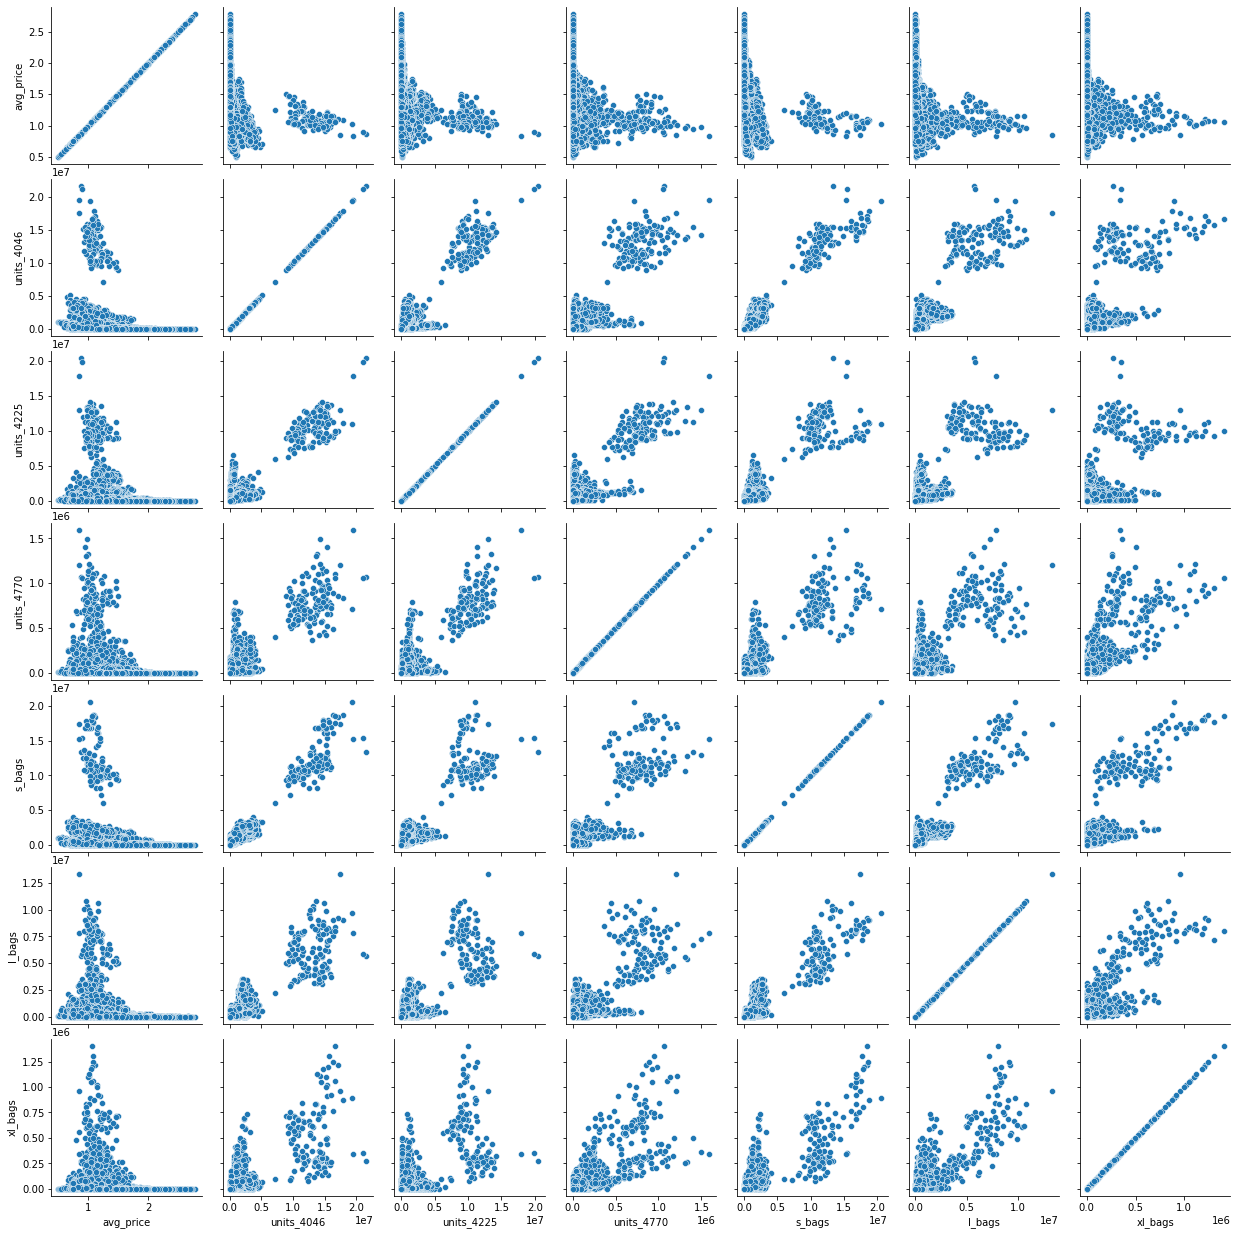

In [8]:
# Compare prices to volumes
g = sns.PairGrid(source_df[['avg_price', 'units_4046', 'units_4225',
                           'units_4770', 's_bags', 'l_bags', 'xl_bags']])
g.map(sns.scatterplot)

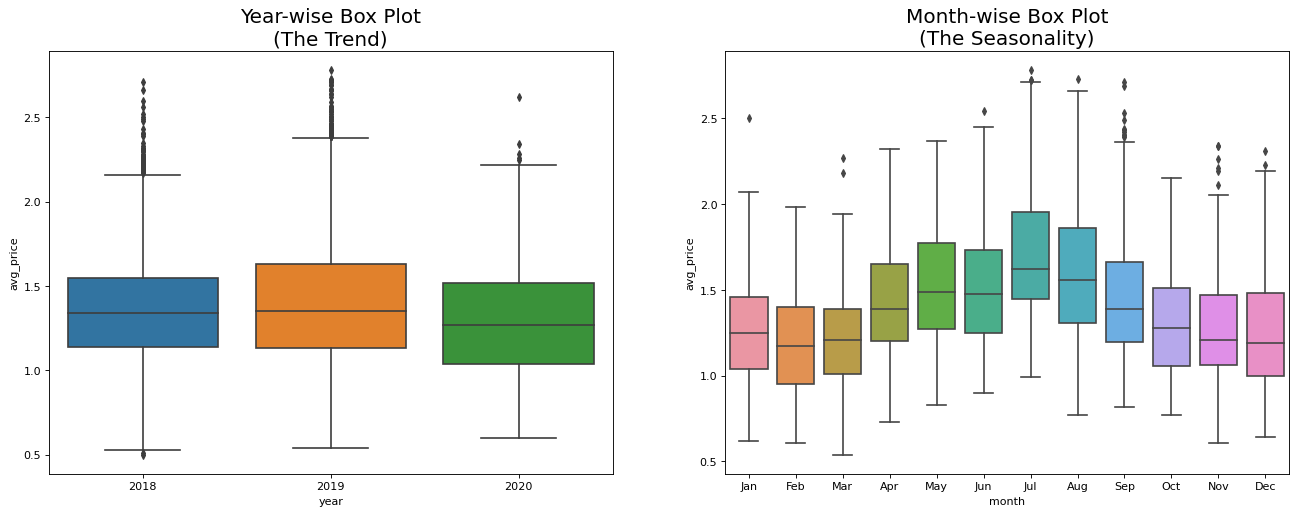

In [9]:
# Prepare data
prices_df['year'] = [d.year for d in prices_df.date]
prices_df['month'] = [d.strftime('%b') for d in prices_df.date]
years = prices_df['year'].unique()

# Draw Plot
fig, axes = plt.subplots(1, 2, figsize=(20,7), dpi= 80)
sns.boxplot(x='year', y='avg_price', data=prices_df, ax=axes[0])
sns.boxplot(x='month', y='avg_price', data=prices_df.loc[~prices_df.year.isin([2018, 2020]), :])            
# Set Title
axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[1].set_title('Month-wise Box Plot\n(The Seasonality)', fontsize=18)
plt.show()

LSTM Data Preparation

In [10]:
lstmconv_df.to_csv('lstm_cleaned_conv_prices.csv')
lstmorg_df.to_csv('lstm_cleaned_org_prices.csv')

Data pipeline including lags

In [11]:
# read in data
dataset = pd.read_csv('lstm_cleaned_conv_prices.csv', header=0, index_col=0)
dataset

,date,geography,avg_price,units_4046,units_4225,units_4770,s_bags,l_bags,xl_bags
0,2018-01-07,Albany,1.13,2940.63,76192.61,42.63,8633.09,10707.93,23.33
2,2018-01-07,Atlanta,0.98,364463.12,47869.41,1459.65,217644.43,78287.66,4191.53
4,2018-01-07,Baltimore/Washington,1.50,89883.07,466602.79,4167.07,189304.53,21356.32,0.00
6,2018-01-07,Boise,1.30,45936.53,2658.28,7511.15,21784.14,7752.83,54.72
8,2018-01-07,Boston,1.28,12012.96,557314.83,4961.24,58834.32,52294.16,0.00
...,...,...,...,...,...,...,...,...,...
14458,2020-09-06,Spokane,1.14,21397.20,13840.24,13.49,51882.19,42531.66,50.87
14460,2020-09-06,StLouis,0.96,117719.22,11917.15,204.55,109526.47,2528.58,12056.42
14462,2020-09-06,Syracuse,1.17,12220.36,41553.12,763.81,33963.49,3097.85,893.33
14464,2020-09-06,Tampa,0.83,295153.76,19274.90,150.36,340468.87,28822.22,13057.78


In [12]:
def series_to_supervised(data, n_in=2, n_out=1, dropnan=False):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

# read in data
dataset = pd.read_csv('lstm_cleaned_org_prices.csv', header=0, index_col=0)

# Generate our categorical variable lists
cat = dataset.dtypes[dataset.dtypes == "object"].index.tolist()


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(dataset[cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat)

# Merge one-hot encoded features and drop the originals
dataset = dataset.merge(encode_df,left_index=True, right_index=True)
dataset = dataset.drop(cat,1)

#Ensure values are float
dataset = dataset.astype('float')


# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled= scaler.fit_transform(dataset)
len(dataset)

# Reframe as supervised learning
reframed = series_to_supervised(scaled, 1, 1)


# drop columns we don't want to predict
reframed.drop(reframed.iloc[:, 190:,], axis=1, inplace=True)
reframed.drop(reframed.index[0], inplace=True)
print(reframed)

      var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1      0.420792   0.000405   0.001249   0.000000   0.021223   0.000029   
2      0.415842   0.003775   0.012714   0.000000   0.038431   0.028304   
3      0.227723   0.012256   0.030192   0.008938   0.345809   0.000058   
4      0.534653   0.000397   0.002876   0.000000   0.002649   0.008852   
5      0.603960   0.000135   0.008196   0.000000   0.122561   0.019765   
...         ...        ...        ...        ...        ...        ...   
2854   0.465347   0.142520   0.089023   0.000000   0.325463   0.007176   
2855   0.410891   0.000127   0.002977   0.000000   0.007244   0.009419   
2856   0.247525   0.011666   0.000006   0.000000   0.043424   0.000000   
2857   0.460396   0.000835   0.004312   0.000000   0.007797   0.016383   
2858   0.163366   0.011673   0.000000   0.000000   0.004791   0.000000   

      var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var181(t-1)  \
1           0.0        1.0        0.0   

In [13]:
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),...,var181(t-1),var182(t-1),var183(t-1),var184(t-1),var185(t-1),var186(t-1),var187(t-1),var188(t-1),var189(t-1),var1(t)
1,0.420792,0.000405,0.001249,0.000000,0.021223,0.000029,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.415842
2,0.415842,0.003775,0.012714,0.000000,0.038431,0.028304,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.227723
3,0.227723,0.012256,0.030192,0.008938,0.345809,0.000058,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.534653
4,0.534653,0.000397,0.002876,0.000000,0.002649,0.008852,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.603960
5,0.603960,0.000135,0.008196,0.000000,0.122561,0.019765,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.237624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854,0.465347,0.142520,0.089023,0.000000,0.325463,0.007176,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.410891
2855,0.410891,0.000127,0.002977,0.000000,0.007244,0.009419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.247525
2856,0.247525,0.011666,0.000006,0.000000,0.043424,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.460396
2857,0.460396,0.000835,0.004312,0.000000,0.007797,0.016383,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.163366


In [14]:
# split into train and test sets
value = reframed
n_train = 2144 # 2018 through 2019
n_features = 190
train = value[:n_train].values
test = value[n_train:].values
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2144, 1, 189) (2144,) (714, 1, 189) (714,)


## Instanciate and fit LSTM model with lags

Epoch 1/100
43/43 - 1s - loss: 0.2226 - val_loss: 0.1244
Epoch 2/100
43/43 - 0s - loss: 0.1057 - val_loss: 0.0986
Epoch 3/100
43/43 - 0s - loss: 0.0975 - val_loss: 0.0907
Epoch 4/100
43/43 - 0s - loss: 0.0939 - val_loss: 0.0885
Epoch 5/100
43/43 - 0s - loss: 0.0934 - val_loss: 0.0913
Epoch 6/100
43/43 - 0s - loss: 0.0943 - val_loss: 0.0940
Epoch 7/100
43/43 - 0s - loss: 0.0980 - val_loss: 0.0887
Epoch 8/100
43/43 - 0s - loss: 0.1000 - val_loss: 0.0967
Epoch 9/100
43/43 - 0s - loss: 0.1005 - val_loss: 0.1277
Epoch 10/100
43/43 - 0s - loss: 0.1065 - val_loss: 0.1390
Epoch 11/100
43/43 - 0s - loss: 0.1150 - val_loss: 0.1026
Epoch 12/100
43/43 - 0s - loss: 0.1046 - val_loss: 0.0904
Epoch 13/100
43/43 - 0s - loss: 0.0978 - val_loss: 0.0899
Epoch 14/100
43/43 - 0s - loss: 0.0977 - val_loss: 0.0930
Epoch 15/100
43/43 - 0s - loss: 0.0977 - val_loss: 0.0898
Epoch 16/100
43/43 - 0s - loss: 0.0968 - val_loss: 0.0893
Epoch 17/100
43/43 - 0s - loss: 0.0934 - val_loss: 0.0973
Epoch 18/100
43/43 - 0s

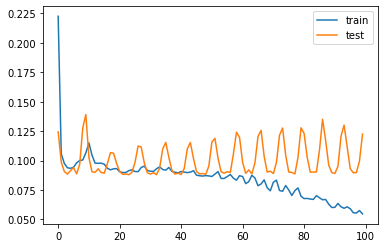

Test RMSE: 0.294


In [15]:
# design network
model = Sequential()
model.add(LSTM(150, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=50, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(
    test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


In [16]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
print(inv_yhat.shape,inv_y.shape )

(2144, 1, 189) (2144,) (714, 189) (714, 1)
(714,) (714,)


In [17]:
# loss, accuracy = model.evaluate(train_X, train_y)

Multiple Lag Model

(2856, 756)
Epoch 1/100
30/30 - 1s - loss: 0.2802 - val_loss: 0.1144
Epoch 2/100
30/30 - 0s - loss: 0.1194 - val_loss: 0.1100
Epoch 3/100
30/30 - 0s - loss: 0.1055 - val_loss: 0.1105
Epoch 4/100
30/30 - 0s - loss: 0.1000 - val_loss: 0.1076
Epoch 5/100
30/30 - 0s - loss: 0.0959 - val_loss: 0.1050
Epoch 6/100
30/30 - 0s - loss: 0.0929 - val_loss: 0.1033
Epoch 7/100
30/30 - 0s - loss: 0.0912 - val_loss: 0.1022
Epoch 8/100
30/30 - 0s - loss: 0.0900 - val_loss: 0.1036
Epoch 9/100
30/30 - 0s - loss: 0.0891 - val_loss: 0.1093
Epoch 10/100
30/30 - 0s - loss: 0.0890 - val_loss: 0.1159
Epoch 11/100
30/30 - 0s - loss: 0.0901 - val_loss: 0.1108
Epoch 12/100
30/30 - 0s - loss: 0.0908 - val_loss: 0.1007
Epoch 13/100
30/30 - 0s - loss: 0.0930 - val_loss: 0.1029
Epoch 14/100
30/30 - 0s - loss: 0.0987 - val_loss: 0.0995
Epoch 15/100
30/30 - 0s - loss: 0.1033 - val_loss: 0.1073
Epoch 16/100
30/30 - 0s - loss: 0.0954 - val_loss: 0.1215
Epoch 17/100
30/30 - 0s - loss: 0.0947 - val_loss: 0.1089
Epoch 18/10

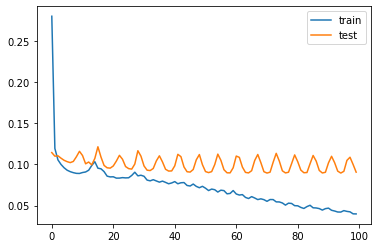

(712, 1) (712, 567)
Test RMSE: 0.236


In [18]:
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('lstm_cleaned_org_prices.csv', header=0, index_col=0)
values = dataset.values

# Generate our categorical variable lists
cat = dataset.dtypes[dataset.dtypes == "object"].index.tolist()


# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(dataset[cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(cat)

# Merge one-hot encoded features and drop the originals
dataset = dataset.merge(encode_df,left_index=True, right_index=True)
dataset = dataset.drop(cat,1)

#Ensure values are float
dataset = dataset.astype('float')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0,1))
scaled= scaler.fit_transform(dataset)
len(dataset)

# specify the number of lag times
n_times = 3
n_features = 189

# frame as supervised learning
reframed = series_to_supervised(scaled, n_times, 1)
print(reframed.shape)
 
# drop columns we don't want to predict
#reframed.drop(reframed.iloc[:, 168:,], axis=1, inplace=True)
#reframed.drop(reframed.index[0], inplace=True)
#print(reframed.shape)
  
# split into train and test sets
values = reframed.values
n_train = 2144 # 2018 through 2019
train = values[:n_train, :]
test = values[n_train:, :]

#split into input and outputs
n_obs = n_times * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
#print(train_X.shape, train_y.shape,test_X.shape, test_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_times, n_features))
test_X = test_X.reshape((test_X.shape[0], n_times, n_features))
#print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_times*n_features))
print(yhat.shape, test_X.shape)

# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 379:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 379:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

In [19]:
# split into train and test sets
print(train.shape, test.shape)
#split into input and outputs
print(train_X.shape, train_y.shape,test_X.shape, test_y.shape)
# reshape input to be 3D [samples, timesteps, features]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
# make a prediction
print(yhat.shape, test_X.shape)
# invert scaling for forecast
#inv_yhat = concatenate((yhat, test_X[:, 379:]), axis=1)
#inv_yhat = scaler.inverse_transform(inv_yhat)
#inv_yhat = inv_yhat[:,0]
print(inv_yhat.shape)
# invert scaling for actual
#test_y = test_y.reshape((len(test_y), 1))
#inv_y = concatenate((test_y, test_X[:, 379:]), axis=1)
#inv_y = scaler.inverse_transform(inv_y)
#inv_y = inv_y[:,0]
print(inv_y.shape)





(2144, 756) (712, 756)
(2144, 3, 189) (2144,) (712, 567) (712, 1)
(2144, 3, 189) (2144,) (712, 567) (712, 1)
(712, 1) (712, 567)
(712,)
(712,)


In [27]:
test_y

array([[0.3019802 ],
       [0.34653465],
       [0.53960396],
       [0.49009901],
       [0.8019802 ],
       [0.72772277],
       [0.32178218],
       [0.28712871],
       [0.57425743],
       [0.37128713],
       [0.28217822],
       [0.42079208],
       [0.30693069],
       [0.35148515],
       [0.47524752],
       [0.42574257],
       [0.56435644],
       [0.46039604],
       [0.24752475],
       [0.52970297],
       [0.46039604],
       [0.44059406],
       [0.42079208],
       [0.27227723],
       [0.27227723],
       [0.36138614],
       [0.17821782],
       [0.35148515],
       [0.27227723],
       [0.48514851],
       [0.32178218],
       [0.31188119],
       [0.5       ],
       [0.35148515],
       [0.52970297],
       [0.44059406],
       [0.37623762],
       [0.52970297],
       [0.50990099],
       [0.35643564],
       [0.41584158],
       [0.47524752],
       [0.31188119],
       [0.37623762],
       [0.34653465],
       [0.31683168],
       [0.54455446],
       [0.653

In [25]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2144, 3, 189) (2144,) (712, 567) (712, 1)


In [26]:
print(yhat.shape, inv_y.shape)

(712, 1) (712,)


In [28]:
reframed

,var1(t-3),var2(t-3),var3(t-3),var4(t-3),var5(t-3),var6(t-3),var7(t-3),var8(t-3),var9(t-3),var10(t-3),...,var180(t),var181(t),var182(t),var183(t),var184(t),var185(t),var186(t),var187(t),var188(t),var189(t)
3,0.420792,0.000405,0.001249,0.000000,0.021223,0.000029,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.415842,0.003775,0.012714,0.000000,0.038431,0.028304,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.227723,0.012256,0.030192,0.008938,0.345809,0.000058,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.534653,0.000397,0.002876,0.000000,0.002649,0.008852,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.603960,0.000135,0.008196,0.000000,0.122561,0.019765,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2854,0.311881,0.000609,0.000578,0.000000,0.014254,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2855,0.316832,0.012053,0.007418,0.000000,0.045005,0.000186,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2856,0.465347,0.142520,0.089023,0.000000,0.325463,0.007176,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2857,0.410891,0.000127,0.002977,0.000000,0.007244,0.009419,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
